In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
#     ###################################################### Q(s,a)= r + Q'(s',a') # max
#     ###################################################### ~Q(s,~a)= r # min
#     ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
#     targetQs = rewards + (gamma * aQs2_logits)
#     eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0000 rate:0.0460 aloss:0.6899 eloss:2.0310 aloss2:1.5252 exploreP:0.9977
Episode:1 meanR:23.5000 R:24.0000 rate:0.0480 aloss:0.6955 eloss:1.9980 aloss2:1.5495 exploreP:0.9954
Episode:2 meanR:20.6667 R:15.0000 rate:0.0300 aloss:0.6898 eloss:2.0407 aloss2:1.5045 exploreP:0.9939
Episode:3 meanR:22.7500 R:29.0000 rate:0.0580 aloss:0.6938 eloss:1.9970 aloss2:1.5449 exploreP:0.9910
Episode:4 meanR:24.0000 R:29.0000 rate:0.0580 aloss:0.6889 eloss:2.0134 aloss2:1.5201 exploreP:0.9882
Episode:5 meanR:25.0000 R:30.0000 rate:0.0600 aloss:0.6882 eloss:1.9792 aloss2:1.5424 exploreP:0.9853
Episode:6 meanR:24.4286 R:21.0000 rate:0.0420 aloss:0.6895 eloss:1.9856 aloss2:1.5207 exploreP:0.9832
Episode:7 meanR:24.0000 R:21.0000 rate:0.0420 aloss:0.6889 eloss:1.9811 aloss2:1.5273 exploreP:0.9812
Episode:8 meanR:25.6667 R:39.0000 rate:0.0780 aloss:0.6928 eloss:1.9553 aloss2:1.5415 exploreP:0.9774
Episode:9 meanR:27.2000 R:41.0000 rate:0.0820 aloss:0.6919 eloss:1.9371 aloss2:1.5

Episode:80 meanR:21.0494 R:23.0000 rate:0.0460 aloss:0.7122 eloss:1.3801 aloss2:2.4060 exploreP:0.8448
Episode:81 meanR:21.0732 R:23.0000 rate:0.0460 aloss:0.6960 eloss:1.4012 aloss2:2.4219 exploreP:0.8429
Episode:82 meanR:21.0120 R:16.0000 rate:0.0320 aloss:0.6944 eloss:1.3589 aloss2:2.5291 exploreP:0.8416
Episode:83 meanR:20.9405 R:15.0000 rate:0.0300 aloss:0.7099 eloss:1.3819 aloss2:2.4802 exploreP:0.8403
Episode:84 meanR:20.9412 R:21.0000 rate:0.0420 aloss:0.7121 eloss:1.3825 aloss2:2.4854 exploreP:0.8386
Episode:85 meanR:20.9535 R:22.0000 rate:0.0440 aloss:0.7001 eloss:1.3762 aloss2:2.4785 exploreP:0.8368
Episode:86 meanR:21.0805 R:32.0000 rate:0.0640 aloss:0.6934 eloss:1.3798 aloss2:2.4466 exploreP:0.8341
Episode:87 meanR:21.3977 R:49.0000 rate:0.0980 aloss:0.7064 eloss:1.3804 aloss2:2.5099 exploreP:0.8301
Episode:88 meanR:21.3258 R:15.0000 rate:0.0300 aloss:0.7073 eloss:1.3849 aloss2:2.5013 exploreP:0.8289
Episode:89 meanR:21.3000 R:19.0000 rate:0.0380 aloss:0.7190 eloss:1.3314 

Episode:159 meanR:21.2700 R:18.0000 rate:0.0360 aloss:0.6807 eloss:1.2574 aloss2:3.1416 exploreP:0.7096
Episode:160 meanR:21.2100 R:10.0000 rate:0.0200 aloss:0.6920 eloss:1.1938 aloss2:3.0952 exploreP:0.7089
Episode:161 meanR:21.1000 R:13.0000 rate:0.0260 aloss:0.6805 eloss:1.1857 aloss2:3.1113 exploreP:0.7080
Episode:162 meanR:21.1500 R:25.0000 rate:0.0500 aloss:0.6874 eloss:1.2502 aloss2:3.1210 exploreP:0.7062
Episode:163 meanR:21.2600 R:31.0000 rate:0.0620 aloss:0.6891 eloss:1.2013 aloss2:3.1310 exploreP:0.7041
Episode:164 meanR:21.4700 R:42.0000 rate:0.0840 aloss:0.6917 eloss:1.1960 aloss2:3.2022 exploreP:0.7012
Episode:165 meanR:21.5500 R:20.0000 rate:0.0400 aloss:0.6948 eloss:1.2295 aloss2:3.2256 exploreP:0.6998
Episode:166 meanR:21.6300 R:24.0000 rate:0.0480 aloss:0.6885 eloss:1.2091 aloss2:3.2072 exploreP:0.6981
Episode:167 meanR:21.7000 R:18.0000 rate:0.0360 aloss:0.7038 eloss:1.2490 aloss2:3.2313 exploreP:0.6969
Episode:168 meanR:21.7700 R:25.0000 rate:0.0500 aloss:0.6850 elo

Episode:238 meanR:23.7100 R:23.0000 rate:0.0460 aloss:0.6801 eloss:1.1881 aloss2:3.3528 exploreP:0.5870
Episode:239 meanR:23.6800 R:13.0000 rate:0.0260 aloss:0.6901 eloss:1.1954 aloss2:3.3806 exploreP:0.5862
Episode:240 meanR:23.6600 R:26.0000 rate:0.0520 aloss:0.6862 eloss:1.1986 aloss2:3.3612 exploreP:0.5847
Episode:241 meanR:23.7000 R:39.0000 rate:0.0780 aloss:0.6808 eloss:1.1948 aloss2:3.3364 exploreP:0.5825
Episode:242 meanR:24.1000 R:62.0000 rate:0.1240 aloss:0.6859 eloss:1.1850 aloss2:3.3464 exploreP:0.5790
Episode:243 meanR:24.0900 R:19.0000 rate:0.0380 aloss:0.6848 eloss:1.1975 aloss2:3.3282 exploreP:0.5779
Episode:244 meanR:24.1400 R:20.0000 rate:0.0400 aloss:0.6817 eloss:1.1865 aloss2:3.3444 exploreP:0.5767
Episode:245 meanR:24.3100 R:33.0000 rate:0.0660 aloss:0.6839 eloss:1.1818 aloss2:3.3473 exploreP:0.5749
Episode:246 meanR:24.2600 R:22.0000 rate:0.0440 aloss:0.6836 eloss:1.1798 aloss2:3.3251 exploreP:0.5736
Episode:247 meanR:24.4500 R:32.0000 rate:0.0640 aloss:0.7067 elo

Episode:317 meanR:46.3900 R:21.0000 rate:0.0420 aloss:0.6933 eloss:1.1743 aloss2:3.3853 exploreP:0.3928
Episode:318 meanR:46.3800 R:10.0000 rate:0.0200 aloss:0.7040 eloss:1.2247 aloss2:3.4032 exploreP:0.3924
Episode:319 meanR:46.3300 R:21.0000 rate:0.0420 aloss:0.7203 eloss:1.1705 aloss2:3.4078 exploreP:0.3916
Episode:320 meanR:46.8300 R:68.0000 rate:0.1360 aloss:0.6902 eloss:1.1921 aloss2:3.3944 exploreP:0.3890
Episode:321 meanR:46.7500 R:17.0000 rate:0.0340 aloss:0.6976 eloss:1.1659 aloss2:3.3933 exploreP:0.3883
Episode:322 meanR:46.9600 R:40.0000 rate:0.0800 aloss:0.7131 eloss:1.1703 aloss2:3.4205 exploreP:0.3868
Episode:323 meanR:47.3300 R:55.0000 rate:0.1100 aloss:0.6914 eloss:1.2243 aloss2:3.4303 exploreP:0.3848
Episode:324 meanR:48.3700 R:118.0000 rate:0.2360 aloss:0.6922 eloss:1.1816 aloss2:3.3939 exploreP:0.3804
Episode:325 meanR:48.8000 R:88.0000 rate:0.1760 aloss:0.6816 eloss:1.1775 aloss2:3.4096 exploreP:0.3771
Episode:326 meanR:49.2800 R:86.0000 rate:0.1720 aloss:0.6845 el

Episode:396 meanR:38.0300 R:26.0000 rate:0.0520 aloss:0.7204 eloss:1.2049 aloss2:3.3736 exploreP:0.2827
Episode:397 meanR:38.1100 R:22.0000 rate:0.0440 aloss:0.7086 eloss:1.1839 aloss2:3.3750 exploreP:0.2821
Episode:398 meanR:37.9800 R:9.0000 rate:0.0180 aloss:0.7196 eloss:1.1617 aloss2:3.4053 exploreP:0.2818
Episode:399 meanR:38.0300 R:18.0000 rate:0.0360 aloss:0.7164 eloss:1.1687 aloss2:3.3989 exploreP:0.2813
Episode:400 meanR:38.0500 R:18.0000 rate:0.0360 aloss:0.6935 eloss:1.2899 aloss2:3.4099 exploreP:0.2809
Episode:401 meanR:37.8800 R:10.0000 rate:0.0200 aloss:0.7116 eloss:1.1510 aloss2:3.3928 exploreP:0.2806
Episode:402 meanR:38.0300 R:27.0000 rate:0.0540 aloss:0.6938 eloss:1.2683 aloss2:3.4034 exploreP:0.2799
Episode:403 meanR:38.6700 R:83.0000 rate:0.1660 aloss:0.6951 eloss:1.2021 aloss2:3.3735 exploreP:0.2776
Episode:404 meanR:39.2500 R:70.0000 rate:0.1400 aloss:0.6940 eloss:1.1920 aloss2:3.3870 exploreP:0.2758
Episode:405 meanR:39.8900 R:78.0000 rate:0.1560 aloss:0.6905 elos

Episode:475 meanR:71.6400 R:128.0000 rate:0.2560 aloss:0.9615 eloss:1.2384 aloss2:3.2171 exploreP:0.1476
Episode:476 meanR:72.1000 R:57.0000 rate:0.1140 aloss:0.8745 eloss:1.2530 aloss2:3.2376 exploreP:0.1468
Episode:477 meanR:72.8800 R:87.0000 rate:0.1740 aloss:0.9256 eloss:1.2573 aloss2:3.2363 exploreP:0.1456
Episode:478 meanR:73.4100 R:61.0000 rate:0.1220 aloss:0.9935 eloss:1.2182 aloss2:3.2321 exploreP:0.1448
Episode:479 meanR:74.6600 R:135.0000 rate:0.2700 aloss:0.9024 eloss:1.2646 aloss2:3.2432 exploreP:0.1430
Episode:480 meanR:75.1300 R:56.0000 rate:0.1120 aloss:0.8717 eloss:1.2701 aloss2:3.2228 exploreP:0.1422
Episode:481 meanR:76.2400 R:124.0000 rate:0.2480 aloss:0.8544 eloss:1.2486 aloss2:3.2277 exploreP:0.1406
Episode:482 meanR:76.7200 R:66.0000 rate:0.1320 aloss:0.8496 eloss:1.2732 aloss2:3.2203 exploreP:0.1397
Episode:483 meanR:77.7900 R:135.0000 rate:0.2700 aloss:0.8859 eloss:1.2334 aloss2:3.2220 exploreP:0.1380
Episode:484 meanR:78.2500 R:68.0000 rate:0.1360 aloss:0.8384

Episode:554 meanR:90.5900 R:9.0000 rate:0.0180 aloss:0.7088 eloss:1.1628 aloss2:3.0833 exploreP:0.0788
Episode:555 meanR:89.9000 R:9.0000 rate:0.0180 aloss:0.7306 eloss:1.2339 aloss2:3.0814 exploreP:0.0787
Episode:556 meanR:89.4800 R:10.0000 rate:0.0200 aloss:0.7422 eloss:1.3370 aloss2:3.0866 exploreP:0.0786
Episode:557 meanR:89.0400 R:10.0000 rate:0.0200 aloss:0.7923 eloss:1.1720 aloss2:3.0884 exploreP:0.0786
Episode:558 meanR:88.6900 R:10.0000 rate:0.0200 aloss:0.7520 eloss:1.1811 aloss2:3.0780 exploreP:0.0785
Episode:559 meanR:88.1700 R:8.0000 rate:0.0160 aloss:0.7800 eloss:1.3219 aloss2:3.0990 exploreP:0.0784
Episode:560 meanR:87.4000 R:10.0000 rate:0.0200 aloss:0.7631 eloss:1.2822 aloss2:3.1275 exploreP:0.0784
Episode:561 meanR:86.7700 R:11.0000 rate:0.0220 aloss:0.7659 eloss:1.2817 aloss2:3.1004 exploreP:0.0783
Episode:562 meanR:85.9600 R:10.0000 rate:0.0200 aloss:0.7757 eloss:1.2493 aloss2:3.1001 exploreP:0.0782
Episode:563 meanR:85.4300 R:9.0000 rate:0.0180 aloss:0.7630 eloss:1

Episode:633 meanR:57.8600 R:111.0000 rate:0.2220 aloss:0.6999 eloss:1.3390 aloss2:3.0331 exploreP:0.0573
Episode:634 meanR:58.5400 R:96.0000 rate:0.1920 aloss:0.6998 eloss:1.2695 aloss2:3.0531 exploreP:0.0568
Episode:635 meanR:59.2600 R:101.0000 rate:0.2020 aloss:0.7194 eloss:1.2598 aloss2:3.0623 exploreP:0.0563
Episode:636 meanR:59.6500 R:61.0000 rate:0.1220 aloss:0.7269 eloss:1.3420 aloss2:3.0822 exploreP:0.0561
Episode:637 meanR:62.9500 R:360.0000 rate:0.7200 aloss:0.7116 eloss:1.3071 aloss2:3.0781 exploreP:0.0544
Episode:638 meanR:63.2300 R:104.0000 rate:0.2080 aloss:0.6991 eloss:1.3117 aloss2:3.0545 exploreP:0.0540
Episode:639 meanR:63.4500 R:82.0000 rate:0.1640 aloss:0.7009 eloss:1.3232 aloss2:3.0544 exploreP:0.0536
Episode:640 meanR:63.6600 R:112.0000 rate:0.2240 aloss:0.7016 eloss:1.3682 aloss2:3.0365 exploreP:0.0531
Episode:641 meanR:67.1400 R:464.0000 rate:0.9280 aloss:0.7064 eloss:1.3210 aloss2:3.0226 exploreP:0.0512
Episode:642 meanR:66.2100 R:47.0000 rate:0.0940 aloss:0.70

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

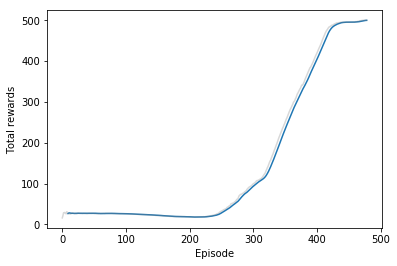

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

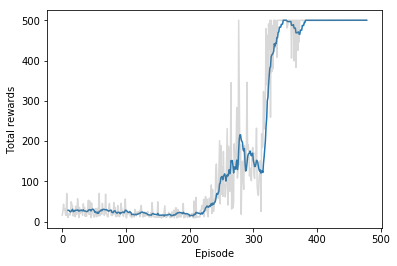

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

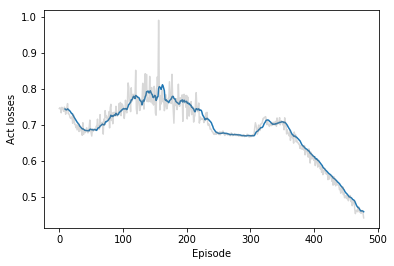

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

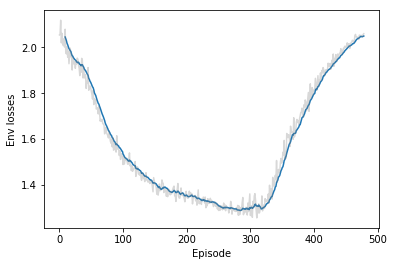

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

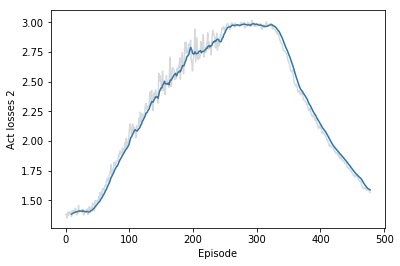

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
